# Computing nucleation rates with GASP

In [1]:
%matplotlib inline

In [2]:
import numpy as np  # Grids are stored as NumPy Arrays
import gasp         # GASP is what we're testing
import sys          # Needed to query size in bytes of data returned

import os.path

Found 1 CUDA devices in this system
Device 0 : Quadro P2000
Number of SMs       : 8
Max SHMEM per block : 48 KB
Max Opt in shared   : 48 KB
Recommended ngrids  : 1024

Estimated largest L for shared memory code path : 109
(Assumes threadsPerBlock = 32)

Using CUDA device : 0


### Run a test nucleation swarm

In [3]:
%%time

L = 64
ngrids = 4*gasp.gpu_nsms*32
nsweeps = 50000
beta = 0.54
h = 0.07

grid_output_int = 100 # Should be a multiple of mag_output_int (not enforced?)
mag_output_int  = 100 # Note that the collective variable (be it magnetisation or cluster size) is computed only at this interval

filename = '-'.join(map(str, (L, ngrids, nsweeps, beta, h, grid_output_int, mag_output_int)))
filename = 'nucleated_fraction'+filename

if not os.path.isfile(filename+'.npz'):
    
    frac = gasp.run_nucleation_swarm(L, ngrids, nsweeps, beta, h, 
                                     grid_output_int = grid_output_int,
                                     mag_output_int=mag_output_int,
                                     keep_grids = False);
    np.savez(filename, frac=frac)

else:

    frac = np.load(filename+'.npz')['frac']

CPU times: user 349 μs, sys: 1.11 ms, total: 1.46 ms
Wall time: 2.72 ms


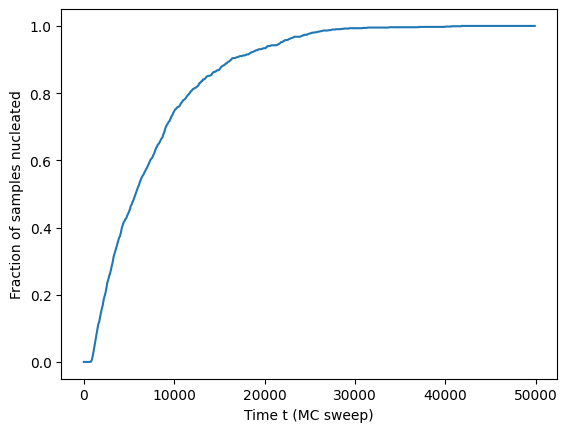

In [4]:
# Plot the fraction nucleated against MC sweep
import matplotlib.pyplot as plt

xdata = [ i * mag_output_int for i in range(nsweeps//mag_output_int)]
plt.ylabel("Fraction of samples nucleated")
plt.xlabel("Time t (MC sweep)")
plt.plot(xdata, frac);

### Fit this to estimate the nucleation rate

Now for some maths.

For an exponential distribution the probability that a nucleation event will occur after time $t$ is:
$$
P(t) = \exp{(-\lambda t)}.
$$
The cumulative probability that it will have occured at a time upto time $t$ is:
$$
C(t) = \int_0^t \exp{(-\lambda t')}\, dt' = 1 - \exp{(-\lambda t)}.
$$
So we want to fit this to our data and extract $\lambda$. If the fit is poor we know this isn't an exponential process, i.e. we're not in the regime where nucleation events are a random Poisson process.



In [5]:
# Define function to fit
import math as m
def fitfunc(t, rate, t_ind):
    return 1.0 - np.exp(-rate*(t-t_ind))    

# Test function
fitfunc(2000, 0.00008, 0)

0.14785621103378865

In [6]:
# Fit it
from scipy.optimize import curve_fit
# We should only fit from the last zero entry to account for induction time
arglist = np.argwhere(frac)
si = arglist[0][0] - 1

popt, pcov = curve_fit(fitfunc, xdata[si:], frac[si:], p0=[0.00008, 1000]) 

print(f"Estimated nucleation rate : {popt[0]/(L*L):e}")

Estimated nucleation rate : 3.551564e-08


Nucleation rate at L=64 : 3.55156e-08 MCSS^-1


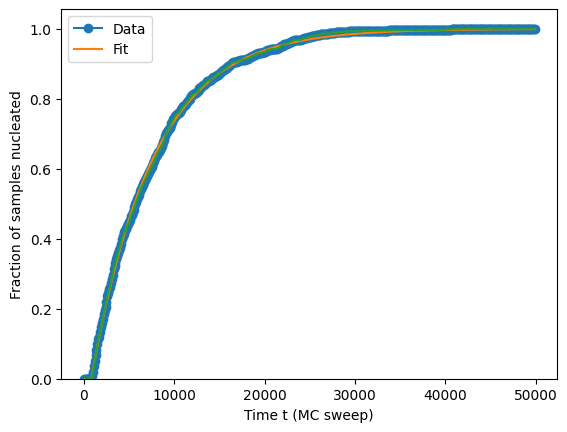

In [7]:
fitdata = [ fitfunc(t, *popt) for t in xdata]
plt.plot(xdata, frac, label="Data", marker='o')
plt.plot(xdata, fitdata, label="Fit")
plt.ylabel("Fraction of samples nucleated")
plt.xlabel("Time t (MC sweep)")
plt.ylim(bottom=0.0)
plt.legend()
plt.plot(xdata, frac);

krate = popt[0]/(L*L)
print(f"Nucleation rate at L={L} : {krate:.5e} MCSS^-1")

### Run with larger L and check for finite size effects
Creating a function for compute nucleation rate as we go

In [8]:
def compute_nucleation_rate(L, ngrids, nsweeps, beta, h):
    ''' Computes nucleation rate. '''

    # Check if a file containing the data for the current inputs exists, if so just load that?
    filename = '-'.join(map(str, (L, ngrids, nsweeps, beta, h, grid_output_int, mag_output_int)))
    filename = 'nucleated_fraction'+filename
    
    if not os.path.isfile(filename+'.npz'):
    
        frac = gasp.run_nucleation_swarm(L, ngrids, nsweeps, beta, h, 
                                         grid_output_int = grid_output_int,
                                         mag_output_int=mag_output_int,
                                         keep_grids = False);
        np.savez(filename, frac=frac)

    else:

        frac = np.load(filename+'.npz')['frac']

    if frac[-1] < 1.0/ngrids:
        # Nothing nucleated return zero as the nucleation rate
        return 0.0
    
    xdata = [ i * mag_output_int for i in range(nsweeps//mag_output_int)]
    arglist = np.argwhere(frac)
    si = arglist[0][0] - 1

    popt, pcov = curve_fit(fitfunc, xdata[si:], frac[si:], p0=[0.00008, 1000]) 
    krate = popt[0]/(L*L) # Rate per unit area / rate per lattice site.
    return krate

In [9]:
L=100
krate = compute_nucleation_rate(L, ngrids, nsweeps, beta, h)
print(f"Nucleation rate at L={L} : {krate:.5e} MCSS^-1")

Nucleation rate at L=100 : 3.70469e-08 MCSS^-1


At this point we've got a problem. We want to know if the difference between the $L=64$ and $L=100$ rates is statistically significant but we don't have an error bar. 

### Estimating uncertainty on the nucleation rate

First let's repeat the above exercise at $L=64$ `Nrepeats` times. That will give us an idea of the true variance of our estimate. We can then use this to validate however we decide to estimate out error bars.

In [10]:
L=64
Nrepeats = 20
fracs = []
for irep in range(Nrepeats):

    # Check if a file containing the data for the current inputs exists, if so just load that?
    filename = '-'.join(map(str, (L, ngrids, nsweeps, beta, h, grid_output_int, mag_output_int, irep)))
    filename = 'nucleated_fraction'+filename
    
    if not os.path.isfile(filename+'.npz'):
    
        frac = gasp.run_nucleation_swarm(L, ngrids, nsweeps, beta, h, 
                                         grid_output_int = grid_output_int,
                                         mag_output_int=mag_output_int,
                                         keep_grids = False);
        np.savez(filename, frac=frac)

    else:

        frac = np.load(filename+'.npz')['frac']

    fracs.append(frac) # List of Numpy arrays

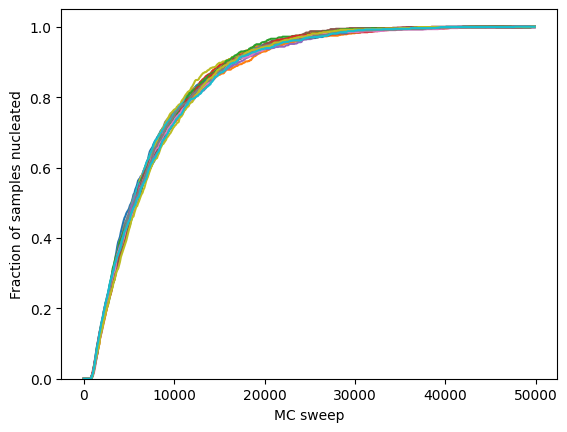

In [11]:
# Plot these on one graph to get an idea of how different they are
for irep in range(Nrepeats):
    plt.plot(xdata, fracs[irep])
plt.ylabel("Fraction of samples nucleated")
plt.xlabel("MC sweep")
plt.ylim(bottom=0.0)
plt.show()

In [12]:
# Loop over these repeats and compute the nucleation rate for each
krates = []
for frac in fracs:
    arglist = np.argwhere(frac)
    si = arglist[0][0] - 1

    popt, _ = curve_fit(fitfunc, xdata[si:], frac[si:], p0=[0.00008, 1000]) 
    krates.append(popt[0]/(L*L))

In [13]:
import statistics as stats

# Max, min and stdev of these
print(f"Maximum rate estimate : {max(krates)}")
print(f"Minimum rate estimate : {min(krates)}")
print(f"Standard Deviation    : {stats.stdev(krates)}")
print(f"Width of 95% confidence interval : {1.96*stats.stdev(krates)}")

Maximum rate estimate : 3.850283113550553e-08
Minimum rate estimate : 3.443608086721939e-08
Standard Deviation    : 1.2285670041955396e-09
Width of 95% confidence interval : 2.4079913282232574e-09


So a 95% confidence interval would be $\pm $ 2.4e-9 or $\pm$ 7%. That's similar in magnitude to the difference between the $L=64$ and $L=100$ case when I run this with `ngrids=1024`. 

The question is how to estimate this confidence interval without doing 20 repeats of the entire calculation. What we can't do is any method that assumes the fraction nucleated at any time $t$ is an independent random variable (binomial) to the fraction nucleated at previous times. That rules out resampling points from a single curve.

What we *can* do is treat the increments from one sampled time to the next as binomial. 

Let $n$ be the total number of grids and $K(t)$ be the cumulative count of the grids that have nucleated, i.e. the function we get out of GASP multiplied by $n$. 

In the time interval between $t_{i-1}$ and $t_{i}$:

- The number of grids that might nucleate is $n-K(t)$. This is the "risk set" $R_{i-1}$.
- $\Delta K_i = K(t_i) - K(t_{i-1})$ is random variable representing how many grids nucleate during the interval.
- If the nucleation is a Poisson process then $\Delta K_i = \mathrm{Binomial}(R_{i-1}, p_i)$ where $p_i = 1 - e^{-\lambda \Delta t_i}$.

In other words the number of grids nucleated in the interval is itself a Poisson process with the same rate as the overall process, but with a smaller time interval and only the grids that haven't nucleated to draw from.  $\Delta K_i$ is drawn from a binomial process, i.e. we draw $R_{i-1}$ samples and the probability that each nucleates is $p_i$ - the total probability of an event occuring over time interval $\Delta t_i$. 

We now have a model for the increments, with parameter $\lambda$, so we can use maximum likelihood estimation (MLE) to find the value of $\lambda$ which best fits the data from GASP. 

The log-likelihood $l(\lambda)$ for a binomial model means we should maximise

$$
l(\lambda) = \sum_i \left[ 
\Delta K_i \log{p_i} + (R_{i-1} - \Delta K_i) \log{(1-p_i)}
\right]
$$

with respect to $p_i$, noting that in our case all the $p_i$ are the same because all the $\Delta t$ are the same. So we just need to find where the "score"

$$
 U(\lambda) = \frac{d l(\lambda)}{ d\lambda} 
$$

is equal to zero and rearrange for $\lambda$ to get the rate. The second derivative of $l(\lambda)$ with respect to $\lambda$ the Fisher information $I(\lambda)$ then tells us how narrow this maximum is and can be used to estimate the uncertainty on the optimised $\lambda$.

$$
SE(\lambda) \approx \frac{1}{\sqrt{I(\hat{\lambda})}}
$$
Here $\hat{\lambda}$ is the optimised $\lambda$.


The following (mostly generated by CoPilot) implements this using Newton-Raphson maximisation. 

In [14]:
def lambda_from_increments(n, t_points, K_cum, max_iter=1000, tol=1e-10):
    """
    n: total systems
    t_points: increasing array of times [t1, ..., tm]
    K_cum: cumulative events at those times [K(t1), ..., K(tm)]
    Returns MLE via Newton-Raphson on the binomial-increments likelihood and SE from observed information.
    """
    t = np.asarray(t_points, dtype=float)
    K = np.asarray(K_cum, dtype=float)
    if np.any(np.diff(t) <= 0):
        raise ValueError("t_points must be strictly increasing")
    if np.any(np.diff(K) < 0) or K[0] < 0 or K[-1] > n:
        raise ValueError("K_cum must be nondecreasing in [0, n]")

    dt = np.diff(np.concatenate(([0.0], t)))
    dK = np.diff(np.concatenate(([0.0], K)))
    R_prev = n - np.concatenate(([0.0], K[:-1]))

    # Initialize lam using overall end-point (single-time estimate)
    p_end = K[-1] / n
    lam = 0.0 if p_end <= 0 else (np.inf if p_end >= 1 else -np.log(1.0 - p_end) / t[-1])

    # Bound initial lam
    if not np.isfinite(lam) or lam <= 0:
        lam = (K[-1] + 1e-6) / (n * t[-1] + 1e-6)

    lconv = False
    for _ in range(max_iter):
        exp_term = np.exp(-lam * dt)
        p = 1.0 - exp_term                 # Binomial increment probs
        p_prime = dt * exp_term            # dp/dlambda = dt * e^{-lambda dt}

        # Score U(lambda) = sum p' * (dK - R_prev * p) / (p*(1-p))
        denom = p * (1.0 - p)
        # Avoid zero denominators
        safe = denom > 0
        U = np.sum(p_prime[safe] * (dK[safe] - R_prev[safe] * p[safe]) / denom[safe])

        # Observed information I(lambda) ~ sum R_prev * (p')^2 / (p*(1-p))
        I = np.sum(R_prev[safe] * (p_prime[safe]**2) / denom[safe])

        step = U / I if I > 0 else 0.0
        lam_new = lam + step
        if lam_new <= 0:
            lam_new = lam / 2.0
        if abs(lam_new - lam) < tol *  lam:
            lam = lam_new
            print(f"Converged estimate of lambda to : {lam}")
            lconv = True
            break
        lam = lam_new


    if not lconv:
        print(f"Reached max iterations before converging to specified tolerance!")

    se = (1.0 / np.sqrt(I)) if I > 0 else np.nan
    ci = (lam - 1.96*se, lam + 1.96*se) if np.isfinite(se) else (np.nan, np.nan)
    return {"lambda_hat": lam, "se": se, "ci95_normal": ci}


print("Fit to CDF   ")
print("=============")


arglist = np.argwhere(frac)
si = arglist[0][0] - 1

popt, pcov = curve_fit(fitfunc, xdata[si:], frac[si:], p0=[0.00008, 1000]) 
t_ind = popt[1]
print(f"Nucleation rate : {popt[0]/(L*L)}")

print("")
print("ML Estimation")
print("=============")

# Compute K(t) from frac and estimate the rate. We shift x because the model
# we're fitting to doesn't know about the induction time.
K = [ f *ngrids for f in frac ] 
shifted_xdata = [ x - t_ind for x in xdata ]

rate_est = lambda_from_increments(ngrids, shifted_xdata[si:], K[si:] )

print(f"Nucleation rate : {rate_est['lambda_hat']/(L*L)}")
print(f"Standard error  : {rate_est['se']/(L*L)}")
print(f"Width of 95% confidence interval : {1.96*rate_est['se']/(L*L)}")

Fit to CDF   
Nucleation rate : 3.4552483304428726e-08

ML Estimation
Converged estimate of lambda to : 0.00014130609907861888
Nucleation rate : 3.449855934536594e-08
Standard error  : 1.078088948927106e-09
Width of 95% confidence interval : 2.113054339897128e-09


This agrees well enough with the standard deviation over our set of repeat calculations, so all good. As a sanity check plot the MLE model against the real data.

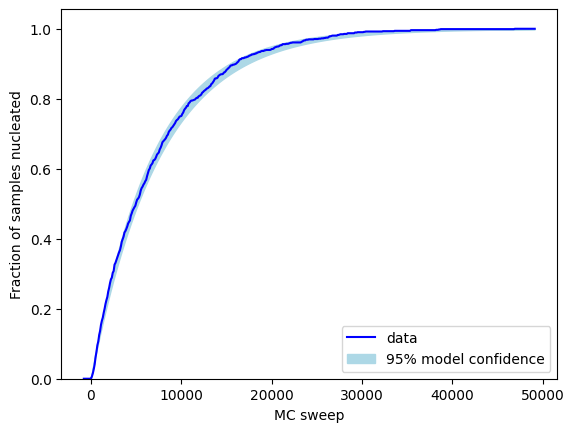

In [20]:
minlam = rate_est['lambda_hat'] - 1.96*rate_est['se']
minmod = [ 1 - np.exp(- minlam * (x - t_ind) ) for x in xdata ]

maxlam = rate_est['lambda_hat'] + 1.96*rate_est['se']
maxmod = [ 1 - np.exp(- maxlam * (x - t_ind) ) for x in xdata ]

plt.plot(shifted_xdata, frac, 'b', label='data')
plt.fill_between(shifted_xdata, minmod, maxmod, color='lightblue', label='95% model confidence' )
plt.ylabel("Fraction of samples nucleated")
plt.xlabel("MC sweep")
plt.ylim(bottom=0.0)
plt.legend()
plt.show()

### Vary external field keeping temperature the same at $\beta=0.54$

In [ ]:
beta = 0.54
L = 64
nsweeps = 500000
grid_output_int = 100000
hlist = np.arange(0.04, 0.11, 0.01) 

In [ ]:
filename="beta"+str(beta)+"_rates"
if not os.path.exists(filename+".npz"):
    klist = [ compute_nucleation_rate(L, ngrids, nsweeps, beta, h)[0] for h in hlist ]
    np.savez(filename, hlist, klist)
else:
    data = np.load(filename+".npz")
    hlist = data['arr_0']
    klist = data['arr_1']

In [ ]:
plt.xlabel('h')
plt.ylabel('k')
plt.plot(hlist, klist, label='beta = '+str(beta))
plt.yscale("log")
plt.legend()

### Keep h the same and vary beta

In [ ]:
h = 0.07
L = 64
nsweeps = 500000
grid_output_int = 100000
blist = np.arange(0.52, 0.61, 0.01) 

In [ ]:
filename="h"+str(h)+"_rates"
if not os.path.exists(filename+".npz"):
    klist = [ compute_nucleation_rate(L, ngrids, nsweeps, beta, h)[0] for beta in blist ]
    np.savez(filename, blist, klist)
else:
    data = np.load(filename+".npz")
    blist = data['arr_0']
    klist = data['arr_1']

In [ ]:
plt.xlabel('beta')
plt.ylabel('k')
plt.plot(blist, klist, label='h = '+str(h))
plt.yscale("log")
plt.legend()

### Vary $h$ at $\beta = 0.53$

In [ ]:
beta = 0.53
L = 64
nsweeps = 500000
grid_output_int = 100000
hlist = np.arange(0.04, 0.11, 0.01) 

In [ ]:
filename="beta"+str(beta)+"_rates"
if not os.path.exists(filename+".npz"):
    klist = [ compute_nucleation_rate(L, ngrids, nsweeps, beta, h)[0] for h in hlist ]
    np.savez(filename, hlist, klist)
else:
    data = np.load(filename+".npz")
    hlist = data['arr_0']
    klist = data['arr_1']

In [ ]:
plt.xlabel('h')
plt.ylabel('k')
plt.plot(hlist, klist, label='beta = '+str(beta))
plt.yscale("log")
plt.legend()

### Vary $h$ at $\beta = 0.55$

In [ ]:
beta = 0.55
L = 64
nsweeps = 500000
grid_output_int = 100000
hlist = np.arange(0.04, 0.11, 0.01) 

In [ ]:

filename="beta"+str(beta)+"_rates"
if not os.path.exists(filename+".npz"):
    klist = [ compute_nucleation_rate(L, ngrids, nsweeps, beta, h)[0] for h in hlist ]
    np.savez(filename, hlist, klist)
else:
    data = np.load(filename+".npz")
    hlist = data['arr_0']
    klist = data['arr_1']

In [ ]:
plt.xlabel('h')
plt.ylabel('k')
plt.plot(hlist, klist, label='beta = '+str(beta))
plt.yscale("log")
plt.legend()

### Vary $h$ at $\beta = 0.56$

In [ ]:
beta = 0.56
L = 64
nsweeps = 500000
grid_output_int = 100000
hlist = np.arange(0.06, 0.11, 0.01) 

In [ ]:
filename="beta"+str(beta)+"_rates"
if not os.path.exists(filename+".npz"):
    klist = [ compute_nucleation_rate(L, ngrids, nsweeps, beta, h)[0] for h in hlist ]
    np.savez(filename, hlist, klist)
else:
    data = np.load(filename+".npz")
    hlist = data['arr_0']
    klist = data['arr_1']

In [ ]:
plt.xlabel('h')
plt.ylabel('k')
plt.plot(hlist, klist, label='beta = '+str(beta))
plt.yscale("log")
plt.legend()

### Vary $h$ at $\beta=0.57$

In [ ]:
beta = 0.57
L = 64
nsweeps = 500000
grid_output_int = 100000
hlist = np.arange(0.07, 0.12, 0.01) 

In [ ]:
filename="beta"+str(beta)+"_rates"
if not os.path.exists(filename+".npz"):
    klist = [ compute_nucleation_rate(L, ngrids, nsweeps, beta, h)[0] for h in hlist ]
    np.savez(filename, hlist, klist)
else:
    data = np.load(filename+".npz")
    hlist = data['arr_0']
    klist = data['arr_1']

### Combine results so far

In [ ]:
plt.xlabel('h')
plt.ylabel('k')
for beta in [0.53, 0.54, 0.55, 0.56, 0.57]:
    filename="beta"+str(beta)+"_rates.npz"
    dat = np.load(filename)
    hlist = dat['arr_0'] ; klist = dat['arr_1']
    plt.plot(hlist, klist, label='beta = '+str(beta), marker="o")

plt.yscale("log")
plt.legend()
plt.grid()